In [1]:
import os
import sys
import re
import time
import matplotlib
import matplotlib.pyplot as plt
import random

parentPath = os.path.abspath("../..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)

import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = parentPath

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

CUSTOM_DIR = "/home/orestisz/repositories/Mask_RCNN/instance_segmentation/custom_data/static_images"

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# import SceneNet
from dataset import *

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
# Validation dataset
dataset = Dataset()
dataset.load(CUSTOM_DIR)
dataset.prepare()

## Detection

In [5]:
class InferenceConfig(Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)
model.load_weights(model.find_last()[1], by_name=True)

/home/orestisz/repositories/Mask_RCNN/instance_segmentation/custom_data/static_images/RGB2.jpg
image_id 1
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000
depth                    shape: (480, 640)            min:    0.00000  max: 2140.00000


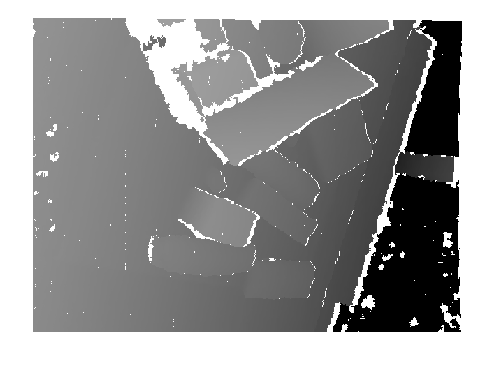

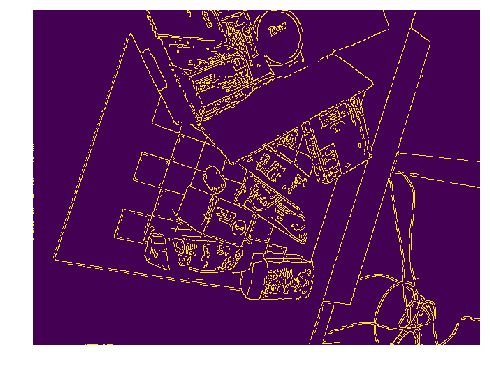

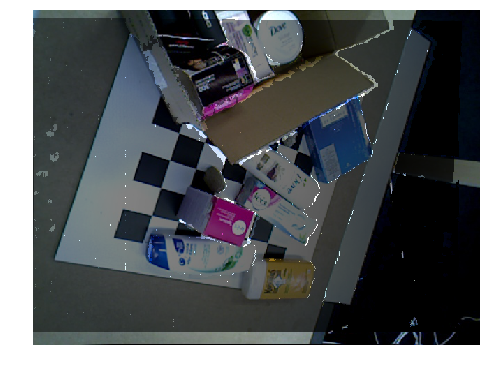

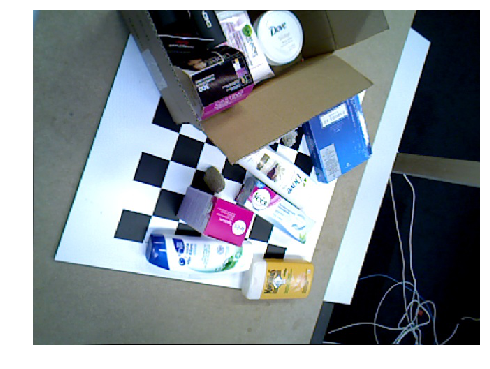

In [8]:
# Test on a random image
image_id = random.choice(dataset.image_ids)
image_id = 1
# image_id = 56
original_image = dataset.load_image(image_id, mode="RGBDE", canny_args=(100, 200))

print(dataset.image_info[image_id]['path'])
image = original_image[:, :, 0:3]
depth = original_image[:, :, 3]
edges = original_image[:, :, 4]
print("image_id", image_id)
log("image", image)
log("depth", depth)

depth_norm = 1.0 - np.clip(depth / min(2 * np.median(depth), np.max(depth)), 0, 1)
rgbd = np.dstack((
    image[:, :, 0] * depth_norm,
    image[:, :, 1] * depth_norm,
    image[:, :, 2] * depth_norm))
rgbd = rgbd.astype(np.uint8)
depth = np.dstack((depth_norm * 255,) * 3)
depth = depth.astype(np.uint8)

ax = get_ax()
ax.axis('off')
ax.imshow(depth)

ax = get_ax()
ax.axis('off')
ax.imshow(edges)

ax = get_ax()
ax.axis('off')
ax.imshow(rgbd)

ax = get_ax()
ax.axis('off')
ax.imshow(image)

2.6841340000000002


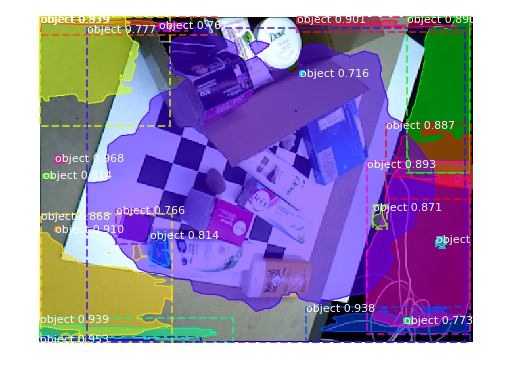

In [9]:
start = time.clock()
r = model.detect([original_image])[0]
print(time.clock() - start)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                    dataset.class_names, r['scores'], ax=get_ax())